<a href="https://colab.research.google.com/github/braxtonowens/Sample_GBDB/blob/main/5D_space_asr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google's Python Environment does not have dscribe(library used to run SOAP) Installed.
# The use of ! in the cell runs terminal command.
# This takes a few minutes to Download :( 
!pip install dscribe
!pip install ase

     |████████████████████████████████| 1.1 MB 4.3 MB/s 
  Using cached pybind11-2.9.1-py2.py3-none-any.whl (211 kB)
     |████████████████████████████████| 2.2 MB 14.0 MB/s 
     |████████████████████████████████| 77 kB 4.4 MB/s 
  Created wheel for dscribe: filename=dscribe-1.2.1-cp37-cp37m-linux_x86_64.whl size=7060731 sha256=dcab93750688cf15b511f8690a5157feebb442fa788526dfbe9e54f7c86f35f0
  Stored in directory: /root/.cache/pip/wheels/39/84/88/a929231f78f78406f35edd8479e3c9cf6464f182af71b55ee3
Successfully built dscribe


In [2]:
!git clone https://github.com/braxtonowens/Sample_GBDB.git


Cloning into 'Sample_GBDB'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 171 (delta 16), reused 107 (delta 0), pack-reused 0
Receiving objects: 100% (171/171), 19.88 MiB | 13.49 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [3]:
#Use ASE to read LAMMPS output files
import ase.io
import os

gbpath = '/content/Sample_GBDB/data_lammps_out'
atoms = []
for i,file in enumerate(os.listdir(gbpath)):
  atoms.append(ase.io.read(os.path.join(gbpath,file)))
  atoms[i].set_atomic_numbers([13 for i in atoms[i]])

In [4]:
# Calculate SOAP for 100 gbs
# This will take a few minutes

from dscribe.descriptors import SOAP

species = ['Al']
rcut = 6.0
nmax = 8
lmax = 6

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
)

allsoap = soap.create(atoms)

In [5]:
def trim_soap(gb, soap, rcut, dim=2):
    # trim off slice of width rcut from the very top and bottom of the GB
    gbCenter = 0
    positions = gb.positions[:, dim]
    trim_top = max(positions)-rcut
    trim_bot = min(positions)+rcut
    idx_del = np.where(np.logical_or(positions > trim_top, positions < trim_bot))[0]

    #delete the given indices from soap along the 0 axis
    trimmed_soap = np.delete(soap,idx_del,0)
    return trimmed_soap

In [6]:
import numpy as np
for i,atom in enumerate(allsoap):
    gb = atoms[i]
    result = trim_soap(gb, allsoap[i], 3.74)

In [7]:
def asr(allsoap, norm_asr=False):
    # for each gb, average and add to matrix, and return
    asr_matrix = []
    magnitude = 1
    for soap in allsoap:
        asr_row = np.average(soap, axis=0)
        if norm_asr is True:
            magnitude = np.linalg.norm(asr_row)
        asr_matrix.append(asr_row / magnitude)
    return np.array(asr_matrix)

In [8]:
asrvec = asr(allsoap)
energies = np.load('/content/Sample_GBDB/energies.npy')
print(np.shape(asrvec))
print(np.shape(energies))

(100, 252)
(100,)


In [50]:
def split_train_test(X,Y,idtrain,idvalid):
    #split the data
    K_train = X[idtrain,:].dot(X[idtrain,:].T) #subset of kernel matrix corresponding to training data
    y_train = Y[idtrain]
    K_valid = X[idvalid,:].dot(X[idtrain,:].T)
    y_valid = Y[idvalid]
    
    #setup model
    Cvalhomer = 1000; gammavalhomer = 'scale'; #(C,gamma) = (1000,100) in Homer paper
    split_train_test.model = SVR(kernel='precomputed',C=Cvalhomer,gamma=gammavalhomer, verbose=False)
    
    #train the model
    split_train_test.model.fit(K_train, y_train)
    
    #make predictions
    y_pred_train = split_train_test.model.predict(K_train)
    y_pred_valid = split_train_test.model.predict(K_valid)
    
    #calculate RMSE
    train_rmse = np.sqrt(np.sum((y_pred_train - y_train)**2)/y_train.shape[0])
    valid_rmse = np.sqrt(np.sum((y_pred_valid - y_valid)**2)/y_valid.shape[0])
    #print('train RMS error: %f' % train_rmse)
    #print('valid RMS error: %f' % valid_rmse)
    
    return (y_train, y_valid, y_pred_train, y_pred_valid, train_rmse, valid_rmse)

In [51]:
#get one random cross val

from sklearn.svm import SVR
from sklearn.model_selection import KFold
import random

ids = range(0,len(energies))
random.seed(9999)
idtrain = np.array(random.sample(ids,int(3*len(energies)/2))) 
idvalid = np.array(list(set(ids).difference(set(idtrain))))

y_train_rand, y_valid_rand, y_pred_train_rand, y_pred_valid_rand, train_rmse_rand, valid_rmse_rand = split_train_test(asrvec,energies,idtrain,idvalid)

(350.0, 550.0)

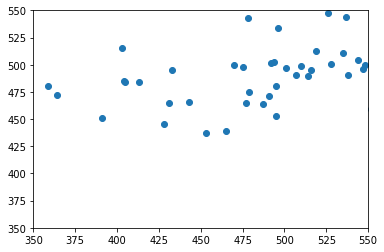

In [52]:
from matplotlib import pyplot as plt
plt.scatter(y_train_rand, y_pred_train_rand)
plt.xlim(350,550)
plt.ylim(350,550)